# Use Decision Tree classifier to classify the new data without libraries

**Step 1: Build the function for classifing the new data using Decision Tree**

**Step 2: Use the inbuilt Sckit Decision Tree classifier to predict the result**

**Step 3: Compare results for both: self-build Decision Tree function and Decision Tree Classifier**

# Step 1: Build Custom Decision Tree model to predict the result

# 1. Import Necessary Libraries and dataset

In [148]:
import random
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # necessary to reduce biases of large numbers
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score 
from sklearn.metrics import accuracy_score 

In [149]:
dataset = pd.read_csv("/kaggle/input/iris-dataset/iris.csv")
dataset

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


# 2. Split the data in training and testing samples

**Dividing the dataset as: 20% of rows are used as testing data**

In [150]:
n_test_samples = int(len(dataset) * 0.2)     # number of test samples

# Combine features and labels into a list of tuples
data = list(dataset.values)
# Set the seed for reproducibility
random.seed(42)
# Shuffle the data in-place
random.shuffle(data)
dataset = pd.DataFrame(data, columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])

test_data = dataset.iloc[:n_test_samples,:].reset_index(drop=True)
#test_labels = dataset.iloc[:n_test_samples,-1].reset_index(drop=True)
train_data = dataset.iloc[n_test_samples:,:].reset_index(drop=True)
#train_labels = dataset.iloc[n_test_samples:,-1].reset_index(drop=True)

print("Number of Samples division:", n_test_samples)
print("Train Dataset length:", len(train_data))
#print("Train Dataset Target length:", len(train_labels))
print("Test Dataset length:", len(test_data))
#print("Test Dataset Target length:", len(test_labels))

Number of Samples division: 30
Train Dataset length: 120
Test Dataset length: 30


**Determine Type of Feature**

Determine each column type in the dataset - if it is categorical or continuous

In [151]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 10
    for feature in dataset.columns:
        if feature != "species":
            unique_values = dataset[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [152]:
type_of_features = determine_type_of_feature(dataset)
for i in range(len(dataset.columns)-1):
    print(dataset.columns[i], ": ", type_of_features[i],'\n')

sepal_length :  continuous 

sepal_width :  continuous 

petal_length :  continuous 

petal_width :  continuous 



# 3. Defining Helper Functions

**Get potential splits**

The `get_potential_splits` function is used to find potential split points for each feature (column) in dataset. These potential split points are used to determine where to split the data during the decision tree construction process, specifically in the `split_data` function, to create branches in the tree based on these split points.

1. It initializes an empty dictionary called `potential_splits` to store the potential split points for each feature.

2. It iterates through the columns of dataset (excluding the last column, which is the label column) using the `for` loop.

3. For each feature (column), it collects the unique values (levels) present in that column using `np.unique(values)`.

4. It checks the `type_of_feature` for the current feature:
   - If the feature is continuous (presumably marked as "continuous" in `type_of_features`), it calculates potential split points. It does this by iterating over the unique values, calculating the midpoint between consecutive unique values, and adding these midpoints to the `potential_splits` list.

   - If the feature is categorical, it simply adds the unique values to the `potential_splits` list. For a categorical feature, the unique values themselves are the potential split points.

5. The function returns the `potential_splits` dictionary, which contains the potential split points for each feature in the dataset.

In [153]:
def get_potential_splits(data):
    
    potential_splits = {}
    #_, n_columns = data.shape
    for column_index in range(len(dataset.columns) - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        type_of_feature = type_of_features[column_index]
        if type_of_feature == "continuous":
            potential_splits[column_index] = []
            for index in range(len(unique_values)):
                if index != 0:
                    current_value = unique_values[index]
                    previous_value = unique_values[index - 1]
                    potential_split = (current_value + previous_value) / 2

                    potential_splits[column_index].append(potential_split)
        
        # feature is categorical
        # (there need to be at least 2 unique values, otherwise in the
        # split_data function data_below would contain all data points
        # and data_above would be empty)
        elif len(unique_values) > 1:
            potential_splits[column_index] = unique_values
    
    return potential_splits

In [154]:
#potentialsplits = get_potential_splits(train_data)
#potentialsplits

**Splitting Data into half based on the Value**

The `split_data` function is used to split a dataset into two parts based on a specified feature and split value. This function takes as input the following parameters:

- `data`: The dataset that you want to split.
- `split_column`: The index of the feature (column) by which you want to split the data.
- `split_value`: The value at which you want to split the data for the specified feature.

1. It first extracts the values of the feature specified by `split_column` from the `data` using `split_column_values = data[:, split_column]`.

2. It determines the type of feature based on `type_of_features[split_column]`. If the feature is marked as "continuous," it proceeds with a continuous split; otherwise, it assumes a categorical feature and performs a categorical split.

3. For a continuous feature, it creates two subsets of the data:
   - `data_below`: Contains the rows where the feature's value is less than or equal to the `split_value`.
   - `data_above`: Contains the rows where the feature's value is greater than the `split_value`.

4. For a categorical feature, it also creates two subsets of the data:
   - `data_below`: Contains the rows where the feature's value equals the `split_value`.
   - `data_above`: Contains the rows where the feature's value is not equal to the `split_value`.

5. The function returns both `data_below` and `data_above` as separate datasets, allowing you to recursively apply the decision tree algorithm on these subsets to build the tree.

In [155]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = type_of_features[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
        
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

**Find the Entropy**

The **entropy** is a crucial metric in the decision tree construction process as it is used to measure the impurity or disorder in a dataset. Lower entropy indicates that the data is more homogeneous, making it a better candidate for a split in the decision tree. The decision tree algorithm aims to minimize the overall entropy by finding the best splits at each node of the tree.

* The `calculate_entropy` function is used to calculate the entropy of a dataset based on the labels in the last column. 
* It computes the entropy by counting the occurrences of each label, calculating the probabilities, and then summing up the entropy contributions from each label.

In [156]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
   
    return entropy

The `calculate_overall_entropy` function is used to calculate the overall entropy of a dataset that has been split into two subsets: `data_below` and `data_above`. It uses the `calculate_entropy` function to calculate the entropy of each subset and then combines them to calculate the overall entropy.

1. It calculates the total number of data points in both `data_below` and `data_above` and stores it in the variable `n`.

2. It calculates the proportion of data in `data_below` (`p_data_below`) and `data_above` (`p_data_above`) with respect to the total number of data points.

3. It calculates the entropy for both `data_below` and `data_above` using the `calculate_entropy` function. This function computes the entropy of the label column in each subset.

4. The weighted sum of the entropies of `data_below` and `data_above` is calculated based on their proportions. This weighted sum is the overall entropy for the dataset after the split.

5. The function returns the calculated overall entropy.

In [157]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

**Find the Information Gain**

**This is an integral part of the decision tree construction process, as it helps identify the optimal splits that lead to the most informative nodes in the decision tree by minimizing impurity or disorder.**

* The aim is to calculate the unique values and their corresponding counts for the feature specified by split_attribute_name.
* Weighted entropy of the dataset is calculated after splitting it by the values of the specified feature. It does the following for each unique value (or branch) of the specified feature:

The `determine_best_split` function is used to find the best feature and value at which to split the data to minimize the overall entropy. This function takes as input the dataset (`data`) and a dictionary of potential splits (`potential_splits`) for each feature. It iterates through the potential splits to determine the best split that results in the lowest overall entropy.

1. It initializes `overall_entropy` to a large value (9999). This value is used as a placeholder to keep track of the minimum overall entropy encountered during the search for the best split.

2. The function enters a nested loop that iterates through each feature (column) in `potential_splits`. For each feature, it further iterates through the potential split values associated with that feature.

3. For each feature and potential split value, the function calls `split_data` to divide the data into two subsets: `data_below` and `data_above`.

4. It calculates the overall entropy after the split using the `calculate_overall_entropy` function, which combines the entropies of `data_below` and `data_above`.

5. If the current overall entropy is less than or equal to the previously recorded `overall_entropy`, the function updates the `overall_entropy`, `best_split_column` (the feature), and `best_split_value` (the value at which to split) to reflect the new best split.

6. The function continues iterating through potential splits and keeps track of the best split found.

7. Finally, it returns the best feature and value at which to split the data to achieve the lowest overall entropy.

In [158]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
         #   print("current_overall_entropy: ",current_overall_entropy )
         #   print("overall_entropy: ",overall_entropy )
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [159]:
#split_column, split_value = determine_best_split(train_data, potentialsplits)
#print("best_split_column: ", split_column)
#print("best_split_value: ", split_value)

In [160]:
#data_below, data_above = split_data(train_data, split_column, split_value)
#print("data_below the split_value: ", data_below)
#print("data_above the split_value: ", data_above)

**Classifier: 1**

The classifier is typically used as a stopping criterion in the decision tree construction process. If a node in the tree is pure, it becomes a leaf node with the class label of the majority class. If it's not pure, the decision tree algorithm continues to find the best features and split points to divide the data further.

The `check_purity` function is used to determine whether a dataset is pure, meaning that all its data points belong to the same class (label). If a dataset is pure, it is not split further in the decision tree construction process, and a leaf node is created with the majority class label.

1. It first extracts the labels (class values) from the last column of the dataset using `label_column = data[:, -1]`.

2. It uses `np.unique(label_column)` to obtain an array of unique class values present in the dataset.

3. It checks the number of unique classes in the dataset. If there's only one unique class, this means that all data points in the dataset belong to the same class, and the dataset is pure.

4. If the number of unique classes is equal to 1 (i.e., `len(unique_classes) == 1`), the function returns `True`, indicating that the dataset is pure.

5. If the number of unique classes is greater than 1, the function returns `False`, indicating that the dataset is not pure, and further splitting is required.

In [161]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

**Classifier: 2**

This function is used to assign a class label to a leaf node in the decision tree, which is reached when a stopping criterion is met, such as the data becoming pure (i.e., all data points belong to the same class) or when a maximum tree depth is reached. The majority class label in the dataset is assigned to the leaf node for classification purposes.

The `classify_data` function is used to assign a class label to a dataset, which typically corresponds to a leaf node in a decision tree. It does this by determining the majority class label in the dataset.

1. It first extracts the labels (class values) from the last column of the dataset using `label_column = data[:, -1]`.

2. It uses `np.unique(label_column, return_counts=True)` to obtain two arrays:
   - `unique_classes`: An array of unique class values present in the dataset.
   - `counts_unique_classes`: An array containing the count of each unique class in the dataset.

3. The function identifies the class with the highest count, which corresponds to the majority class in the dataset. It does this by finding the index of the maximum count using `counts_unique_classes.argmax()`.

4. The `classification` variable is set to the class label with the highest count, which represents the majority class in the dataset.

5. The function returns the `classification` as the predicted class label for the dataset.

In [162]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

# 4. Tree Creation

**This recursive algorithm constructs a decision tree by recursively splitting the data based on the best features and split values, and it continues until it reaches a stopping criterion or maximum tree depth. 
The result is a decision tree that can be used for classification.**
 
The `decision_tree_algorithm` function is the core of a decision tree construction algorithm. It builds a decision tree by recursively splitting the data based on the best features and split points to minimize impurity. 

 **Data Preparation**
*  In the initial call (when `counter` is 0), it prepares the data for tree construction. 
*  It determines the column headers (`COLUMN_HEADERS`) and feature types (`FEATURE_TYPES`).
*  The data is converted to a NumPy array for processing. 
 
**Stopping Criteria**:
* If the data is pure (all data points belong to the same class), it returns the class label.
* If the number of data points is less than `min_samples`, it returns the class label with the majority count.
* If the depth of the tree (controlled by `max_depth`) reaches a specified limit, it returns the class label with the majority count.

**Tree Growing**:
* It increments the `counter` to keep track of the tree depth.
* It computes potential splits for the current data using the `get_potential_splits` function.
* It determines the best split based on the lowest overall entropy using the `determine_best_split` function.
* It splits the data into subsets `data_below` and `data_above` using the `split_data` function.
* It determines the question for the current node based on the feature name and split value.
* It creates a sub-tree with a node representing the question.

**Recursion**:
* It iterates through each unique value of the selected feature, creating a branch for each value.
* The function recursively calls itself on the `data_below` and `data_above` subsets, and the results are stored as the "yes" and "no" answers in the sub-tree.

**Tree Building**:
* If the "yes" and "no" answers are the same, there is no point in asking the question. In this case, the sub-tree becomes the answer itself. If the answers are different, the sub-tree includes the question, "yes" answer, and "no" answer.
*    The final sub-tree is returned, representing the decision tree structure for the given dataset.

In [163]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [164]:
tree = decision_tree_algorithm(train_data, max_depth=8)
pprint(tree)

{'petal_width <= 0.8': ['setosa',
                        {'petal_width <= 1.55': ['versicolor',
                                                 {'petal_length <= 5.05': [{'sepal_width <= 2.9': ['virginica',
                                                                                                   {'petal_width <= 1.75': ['versicolor',
                                                                                                                            {'sepal_width <= 3.1': ['virginica',
                                                                                                                                                    'versicolor']}]}]},
                                                                           'virginica']}]}]}


# 5. Prediction

**This allows to classify individual examples using a trained decision tree, making it a fundamental part of the decision tree classification process.**

**Predict for new values**

The `classify` function is used to classify test data using a trained decision tree. It takes a data set and a decision tree as input and follows the tree's structure to reach a leaf node, where it determines the final classification for the example. Here's how the function works:

1. It begins by extracting the first question from the decision tree. The question is stored as the first (and only) key in the `tree` dictionary. The question is in the form of `"feature_name comparison_operator value"`. It then splits this question into its components: `feature_name`, `comparison_operator`, and `value`.

2. It asks the question by comparing the feature value in the example to the value mentioned in the question:
   - If `comparison_operator` is `"<="`, it checks if the feature value in the example is less than or equal to the value mentioned in the question. If it is, the `answer` is set to the "yes" branch of the tree (`tree[question][0]`); otherwise, it's set to the "no" branch of the tree (`tree[question][1]`).
   - If `comparison_operator` is not `"<="`, it assumes the feature is categorical and checks if the feature value in the example is equal to the value mentioned in the question. If they match, the `answer` is set to the "yes" branch; otherwise, it's set to the "no" branch.

3. It checks if the `answer` is a dictionary. If it's not a dictionary, it means that the current node is a leaf node, and the `answer` contains the class label for classification.

4. If the `answer` is a dictionary, it indicates that further branching is required. The function sets the `residual_tree` to the subtree corresponding to the chosen branch (either "yes" or "no") and recursively calls itself with the `residual_tree`. This process continues until a leaf node is reached.

5. When a leaf node is reached, the function returns the final classification label for the example.

In [165]:
def classify(df, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":  # feature is continuous
        if df[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(df[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    print (answer)
    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify(df, residual_tree)

In [166]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["species"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [167]:
accuracy = calculate_accuracy(test_data, tree)
print(f"Accuracy: {accuracy * 100:.2f}%")

{'petal_width <= 1.55': ['versicolor', {'petal_length <= 5.05': [{'sepal_width <= 2.9': ['virginica', {'petal_width <= 1.75': ['versicolor', {'sepal_width <= 3.1': ['virginica', 'versicolor']}]}]}, 'virginica']}]}
versicolor
{'petal_width <= 1.55': ['versicolor', {'petal_length <= 5.05': [{'sepal_width <= 2.9': ['virginica', {'petal_width <= 1.75': ['versicolor', {'sepal_width <= 3.1': ['virginica', 'versicolor']}]}]}, 'virginica']}]}
versicolor
{'petal_width <= 1.55': ['versicolor', {'petal_length <= 5.05': [{'sepal_width <= 2.9': ['virginica', {'petal_width <= 1.75': ['versicolor', {'sepal_width <= 3.1': ['virginica', 'versicolor']}]}]}, 'virginica']}]}
{'petal_length <= 5.05': [{'sepal_width <= 2.9': ['virginica', {'petal_width <= 1.75': ['versicolor', {'sepal_width <= 3.1': ['virginica', 'versicolor']}]}]}, 'virginica']}
virginica
{'petal_width <= 1.55': ['versicolor', {'petal_length <= 5.05': [{'sepal_width <= 2.9': ['virginica', {'petal_width <= 1.75': ['versicolor', {'sepal_widt

# Step 2: Use Scikit Library to predict the output

**divide the dataset into training and testing** 

In [168]:
n_test_samples = int(len(dataset) * 0.2)     # number of test samples

# Combine features and labels into a list of tuples
data = list(dataset.values)
# Set the seed for reproducibility
random.seed(42)
# Shuffle the data in-place
random.shuffle(data)
dataset = pd.DataFrame(data, columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])

test_df = dataset.iloc[:n_test_samples,:-1].reset_index(drop=True)
test_labels = dataset.iloc[:n_test_samples,-1].reset_index(drop=True)
train_df = dataset.iloc[n_test_samples:,:-1].reset_index(drop=True)
train_labels = dataset.iloc[n_test_samples:,-1].reset_index(drop=True)

print("Number of Samples division:", n_test_samples)
print("Train Dataset length:", len(train_df))
print("Train Dataset Target length:", len(train_labels))
print("Test Dataset length:", len(test_df))
print("Test Dataset Target length:", len(test_labels))

Number of Samples division: 30
Train Dataset length: 120
Train Dataset Target length: 120
Test Dataset length: 30
Test Dataset Target length: 30


**Use Scikit's Decision Tree library to train the model (Building a tree)**

In [169]:
#Train the model
tree = DecisionTreeClassifier(criterion = 'entropy').fit(train_df,train_labels)

**Use Scikit's Decision Tree library to predict the output**

In [170]:
#Predict the classes of new, unseen data
prediction_labels = tree.predict(test_df)

**Use Scikit's Decision Tree library to calculate its accuracy**

In [171]:
#Check the accuracy
acc_decisiontree_test = round(tree.score(test_df,test_labels) * 100, 2)
print("The prediction accuracy is: ",acc_decisiontree_test, '%')

The prediction accuracy is:  96.67 %


# Step 3: Comapre the results for custom Decision Tree implementation with the built-in scikit-learn Decision Tree classifier

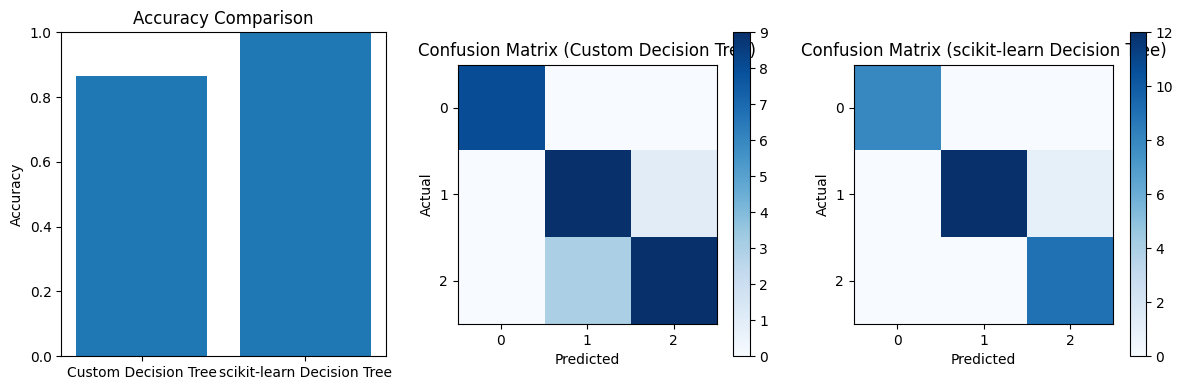

Custom Decision Tree Classification Report:
              precision    recall  f1-score    support
setosa         1.000000  1.000000  1.000000   8.000000
versicolor     0.750000  0.900000  0.818182  10.000000
virginica      0.900000  0.750000  0.818182  12.000000
accuracy       0.866667  0.866667  0.866667   0.866667
macro avg      0.883333  0.883333  0.878788  30.000000
weighted avg   0.876667  0.866667  0.866667  30.000000

scikit-learn Decision Tree Classification Report:
              precision    recall  f1-score    support
setosa         1.000000  1.000000  1.000000   8.000000
versicolor     1.000000  0.923077  0.960000  13.000000
virginica      0.900000  1.000000  0.947368   9.000000
accuracy       0.966667  0.966667  0.966667   0.966667
macro avg      0.966667  0.974359  0.969123  30.000000
weighted avg   0.970000  0.966667  0.966877  30.000000


In [172]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Your custom Decision Tree results
custom_accuracy = accuracy
custom_cm = confusion_matrix(test_data["species"], test_data["classification"])

# scikit-learn Decision Tree results
sklearn_accuracy = acc_decisiontree_test  # Accuracy from scikit-learn Decision Tree
sklearn_predicted_labels = prediction_labels  # Predictions from scikit-learn Decision Tree
sklearn_cm = confusion_matrix(test_labels, sklearn_predicted_labels)

# Visualize the results
plt.figure(figsize=(12, 4))

# Accuracy Comparison
plt.subplot(1, 3, 1)
plt.bar(['Custom Decision Tree', 'scikit-learn Decision Tree'], [custom_accuracy, sklearn_accuracy])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Confusion Matrix Comparison
plt.subplot(1, 3, 2)
plt.title('Confusion Matrix (Custom Decision Tree)')
plt.imshow(custom_cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.colorbar()
plt.xticks(range(len(custom_cm)), range(len(custom_cm)))
plt.yticks(range(len(custom_cm)), range(len(custom_cm)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
plt.title('Confusion Matrix (scikit-learn Decision Tree)')
plt.imshow(sklearn_cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.colorbar()
plt.xticks(range(len(sklearn_cm)), range(len(sklearn_cm)))
plt.yticks(range(len(sklearn_cm)), range(len(sklearn_cm)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Calculate classification report for both models
custom_classification_report = classification_report(test_data["species"], test_data["classification"], output_dict=True)
sklearn_classification_report = classification_report(test_labels, sklearn_predicted_labels, output_dict=True)

# Convert classification reports to DataFrames
import pandas as pd
custom_report_df = pd.DataFrame(custom_classification_report).transpose()
sklearn_report_df = pd.DataFrame(sklearn_classification_report).transpose()

# Display the classification reports in a table format
print("Custom Decision Tree Classification Report:")
print(custom_report_df)

print("\nscikit-learn Decision Tree Classification Report:")
print(sklearn_report_df)